In [319]:
import os
import pandas as pd
import pathlib
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import seaborn as sns

from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ast import literal_eval
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [298]:
# f'cartpole-{time.strftime("%Y%m%d-%H%M%S")}'

In [299]:
writer = SummaryWriter(f'runs/cartpole-{time.strftime("%Y%m%d-%H%M%S")}')
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 1515880), started 1 day, 1:00:25 ago. (Use '!kill 1515880' to kill it.)

## Define Dataset and DataLoader

In [300]:
class CartpoleNLPDataset(Dataset):
    def __init__(self, nlp_results_path, train):
        self.df = pd.read_csv(path)

        # Process columns of the dataframe that contain arrays that are formatted as strings in the csv
        array_elements = ['params', 'X', 'U']
        for elem in array_elements:
            self.df[elem] = self.df[elem].apply(literal_eval) # Convert strings into lists 
            self.df[elem] = self.df[elem].apply(lambda x: np.array(x, dtype=np.float64)) # Convert lists into np arrays of type np.float64

        # Split the data into training and testing sets
        train_df, test_df = train_test_split(self.df, test_size=0.2)

        if train:
            self.df = train_df
        else:
            self.df = test_df

        # Store the number of params (NN inputs) and length of trajectory (NN outputs)
        self.n_params = len(self.df['params'].iloc[0])
        N = self.df['X'].iloc[0].shape[0] # number of timesteps
        n_states = len(self.df['X'].iloc[0][0])
        n_controls = len(self.df['U'].iloc[0][0])

        # print(n_states)
        # print(n_controls)
        # print(N)
        self.n_traj = n_states*N + n_controls*(N-1)

    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        params = self.df.iloc[idx].params
        X = self.df.iloc[idx].X
        U = self.df.iloc[idx].U
        
        Z = np.array([np.hstack((X[i], U[i])) for i in range(len(U))], dtype=np.float64) # create the trajectory vector where element z_i = [x_i, u_i]
        Z = Z.flatten()
        # print(Z[-6:])
        # print(Z.shape)
        Z = np.concatenate((Z, X[-1])) # add the final state to the end of the trajectory
        # print(Z[-6:])
        # print(Z.shape)
        # print()

        return params, Z
    def getitem(self, idx):
        params = self.df.iloc[idx].params
        X = self.df.iloc[idx].X
        U = self.df.iloc[idx].U
        
        Z = np.array([np.hstack((X[i], U[i])) for i in range(len(U))]) # create the trajectory vector where element z_i = [x_i, u_i]
        
        return params, Z

    

In [301]:
path = 'data/cartpole_DIRCOL_5000.csv'
train_data = CartpoleNLPDataset(path, train=True)
test_data = CartpoleNLPDataset(path, train=False)
# print(train_data.getitem(0)[1].dtype)
print(train_data.n_traj)

train_dataloader = DataLoader(train_data, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=True)

params, Z = next(iter(train_dataloader))
# print(params.shape)
# print(Z.shape)


204


In [302]:
cartpole_data = CartpoleNLPDataset(path, train=True)
cartpole_data.n_params
cartpole_data.n_traj
# cartpole_data.df['X'].iloc[0].shape[0]

204

## Define the NN

In [303]:
class CartpoleNN(nn.Module):
    def __init__(self, n_params, n_traj):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(n_params, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, n_traj)
        )
        self.linear_relu_stack = self.linear_relu_stack.double()

        
    def forward(self, params):
        # params = self.flatten(params)
        traj = self.linear_relu_stack(params)
        return traj


In [304]:
model = CartpoleNN(cartpole_data.n_params, cartpole_data.n_traj).to(device)
print(f"Model structure: {model}\n\n")

# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")


Model structure: CartpoleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=204, bias=True)
  )
)




## Training Loop

In [305]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    train_loss = 0
    for batch, (X,y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)



        pred = model(X)
        loss = loss_fn(pred, y)

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    train_loss /= len(dataloader)
    # loss, current = loss.item(), batch * len(X)
    # print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_loss
            


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches # average loss per batch
    # print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")


    return test_loss



In [306]:
learning_rate = 5e-3
batch_size = 64
epochs = 100

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

for t in tqdm(range(epochs)):
    # print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    scheduler.step()
    writer.add_scalar('train loss x epoch', train_loss, t)

    test_loss = test_loop(test_dataloader, model, loss_fn)
    writer.add_scalar('test loss x epoch', test_loss, t)



writer.flush()
writer.close()
print("Done!")


100%|██████████| 100/100 [01:39<00:00,  1.01it/s]

Done!


## Visualize the MLP Generated Warm-Start

In [307]:
# model = torch.load('models/cartpole_model1.pth')
model.eval()
# rand_param = torch.rand()

param_lower = [0.0, 0.0]
param_upper = [0.2, np.pi/2]

rand_param = torch.rand(len(param_lower)) * (torch.tensor(param_upper) - torch.tensor(param_lower)) + torch.tensor(param_lower)
rand_param = rand_param.double()

Z = None
with torch.no_grad():
    # rand_param = rand_param.to(device)
    test_param  = torch.from_numpy(test_data.df.iloc[1].params)
    test_param = test_param.to(device)
    start = time.process_time()
    Z = model(test_param)
    end = time.process_time()
Z = Z.detach().cpu().numpy()

print(end-start)


0.0002463539999553177


0.8214461803436279
idx(nx=4, nu=1, N=41, nz=204, nc=160, X=[array([0, 1, 2, 3]), array([5, 6, 7, 8]), array([10, 11, 12, 13]), array([15, 16, 17, 18]), array([20, 21, 22, 23]), array([25, 26, 27, 28]), array([30, 31, 32, 33]), array([35, 36, 37, 38]), array([40, 41, 42, 43]), array([45, 46, 47, 48]), array([50, 51, 52, 53]), array([55, 56, 57, 58]), array([60, 61, 62, 63]), array([65, 66, 67, 68]), array([70, 71, 72, 73]), array([75, 76, 77, 78]), array([80, 81, 82, 83]), array([85, 86, 87, 88]), array([90, 91, 92, 93]), array([95, 96, 97, 98]), array([100, 101, 102, 103]), array([105, 106, 107, 108]), array([110, 111, 112, 113]), array([115, 116, 117, 118]), array([120, 121, 122, 123]), array([125, 126, 127, 128]), array([130, 131, 132, 133]), array([135, 136, 137, 138]), array([140, 141, 142, 143]), array([145, 146, 147, 148]), array([150, 151, 152, 153]), array([155, 156, 157, 158]), array([160, 161, 162, 163]), array([165, 166, 167, 168]), array([170, 171, 172, 173]), array([175, 1

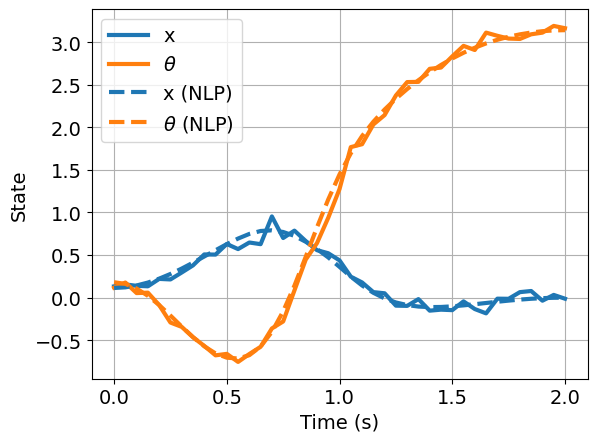

In [318]:
from utils.trajectory_utils import create_idx
nx, nu, N = 4, 1, 41
# nx, nu, N, nz, nc, x, u, c= create_idx(nx, nu, N)
idx = create_idx(nx, nu, N)

t_vec = np.linspace(0, 2, N)

print(test_data.df.iloc[2].solve_time_sec)

print(idx)
plt.plot(t_vec, Z[idx.X][:,:2], linewidth=3.0)
plt.plot(t_vec, test_data.df.iloc[1].X[:,0], '--', linewidth=3.0, color='tab:blue')
plt.plot(t_vec, test_data.df.iloc[1].X[:,1], '--', linewidth=3.0, color='tab:orange')

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}

plt.grid(True)
mpl.rc('font', **font)

plt.xlabel('Time (s)')
plt.ylabel('State')
plt.legend(['x', r'$\theta$', 'x (NLP)', r'$\theta$ (NLP)'])

In [ ]:
print(idx.x)

[array([0, 1, 2, 3]), array([5, 6, 7, 8]), array([10, 11, 12, 13]), array([15, 16, 17, 18]), array([20, 21, 22, 23]), array([25, 26, 27, 28]), array([30, 31, 32, 33]), array([35, 36, 37, 38]), array([40, 41, 42, 43]), array([45, 46, 47, 48]), array([50, 51, 52, 53]), array([55, 56, 57, 58]), array([60, 61, 62, 63]), array([65, 66, 67, 68]), array([70, 71, 72, 73]), array([75, 76, 77, 78]), array([80, 81, 82, 83]), array([85, 86, 87, 88]), array([90, 91, 92, 93]), array([95, 96, 97, 98]), array([100, 101, 102, 103]), array([105, 106, 107, 108]), array([110, 111, 112, 113]), array([115, 116, 117, 118]), array([120, 121, 122, 123]), array([125, 126, 127, 128]), array([130, 131, 132, 133]), array([135, 136, 137, 138]), array([140, 141, 142, 143]), array([145, 146, 147, 148]), array([150, 151, 152, 153]), array([155, 156, 157, 158]), array([160, 161, 162, 163]), array([165, 166, 167, 168]), array([170, 171, 172, 173]), array([175, 176, 177, 178]), array([180, 181, 182, 183]), array([185, 18

## Go through the test dataset and store the MLP generated warmstart trajectories

In [346]:
warmstart_df = test_data.df.copy()
warmstart_df.shape

warmstart_df['X_warmstart'] = None
warmstart_df['U_warmstart'] = None
warmstart_df['inference_time_sec'] = None


# warmstart_df.head()
for index, row in warmstart_df.iterrows():
    test_param  = torch.from_numpy(row.params)
    test_param = test_param.to(device)
    
    with torch.no_grad():
        start = time.process_time()
        Z = model(test_param)
        end = time.process_time()
    Z = Z.detach().cpu().numpy()

    warmstart_df.at[index, 'inference_time_sec'] = end - start
    warmstart_df.at[index, 'X_warmstart'] = Z[idx.X]
    warmstart_df.at[index, 'U_warmstart'] = Z[idx.U]
    # warmstart_df.['inference_time_sec'] = end-start
    # row['X_warmstart'] = Z[idx.X]
    # row['U_warmstart'] = Z[idx.U]
    # print(row)


warmstart_df.head()



,params,X,U,obj,solve_time_sec,term_status,X_warmstart,U_warmstart,inference_time_sec
1805,"[0.05920853827155932, 0.3333795441858658]","[[0.05920853827155932, 0.3333795441858658, 0.0...","[[5.63592525538214], [4.1823623804612], [3.261...",404.681164,0.861292,LOCALLY_SOLVED,"[[0.14375824105130586, 0.27514144917434297, 0....","[[6.161164180841104], [4.562550409297904], [3....",0.000297
686,"[0.11343489437191655, 0.1809547309197721]","[[0.11343489437191655, 0.1809547309197721, 0.0...","[[5.775969935731567], [5.0262228806393265], [4...",399.100781,1.118433,LOCALLY_SOLVED,"[[0.13252763649385063, 0.116787720809163, 0.02...","[[5.922662076198471], [4.3651864535506295], [3...",0.000161
1961,"[0.06871706163435667, 0.8410046121793401]","[[0.06871706163435667, 0.8410046121793401, 0.0...","[[7.104233764015561], [4.466342501146422], [2....",442.142127,0.821446,LOCALLY_SOLVED,"[[0.1372015737814913, 0.8683242627398952, -0.0...","[[7.062479658369358], [5.344470352835174], [3....",0.000158
75,"[0.09423013386103428, 1.0250673331518787]","[[0.09423013386103428, 1.0250673331518787, 0.0...","[[7.533574992978043], [5.116480039480879], [2....",461.907692,0.580487,LOCALLY_SOLVED,"[[0.09719764042824543, 1.0785764065550458, -0....","[[7.402523173946175], [5.6515531259772445], [3...",0.000152
487,"[0.04949806558544421, 1.4294084221091876]","[[0.04949806558544421, 1.4294084221091876, 0.0...","[[8.499280334664922], [7.547195447676404], [5....",514.018352,0.861411,LOCALLY_SOLVED,"[[0.0432343517764439, 1.4308620839258752, 0.00...","[[8.272809858857705], [6.453060338468174], [4....",0.000149


In [361]:
warmstart_df.to_csv('data/warmstart_cartpole.csv')


## Visualize histograms for solve time

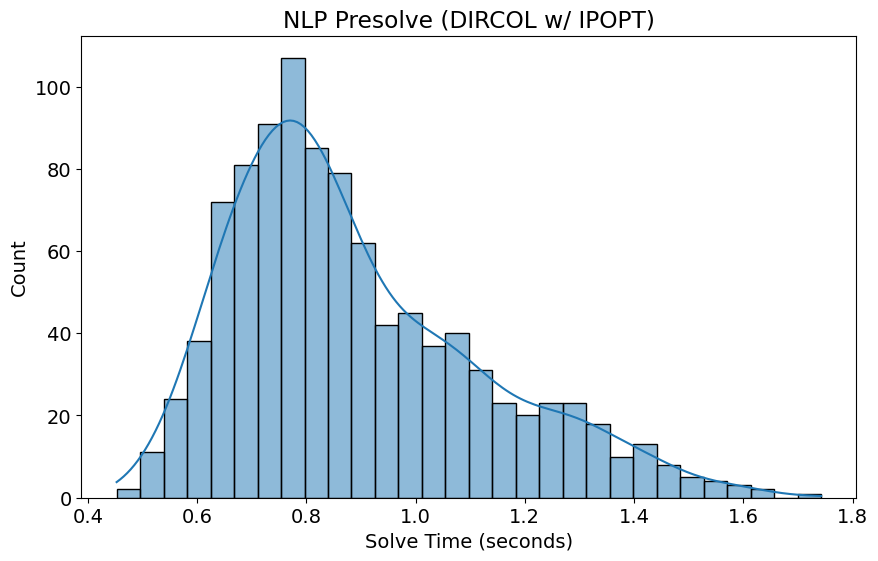

In [360]:
plt.figure(figsize=(10, 6))
sns.histplot(warmstart_df['solve_time_sec'], bins=30, kde=True)
plt.xlabel('Solve Time (seconds)')
plt.ylabel('Count')
plt.title('NLP Presolve (DIRCOL w/ IPOPT)')
plt.show()